
<img src=https://www.iteda.cnea.gov.ar/sites/default/files/garland_iteda_logo.png align='left' height=115>

<img src=https://www.facet.unt.edu.ar/facetinforma/wp-content/uploads/sites/9/2015/11/it-OP1-Transparente.png align='right' height=115>


  
# Análisis Estadístico de Datos



# Ajuste de un histograma con verosimilitud

Espectro de rayos cósmicos de Auger

<ol>
<li>Todo el espectro</li>
<li>Baja energía </li>
<li>Alta energía</li>
</ol>

In [23]:
import math
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import minimize

In [24]:
# Para cargar archivos alojados en Colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [25]:
# bajar módulo sda.py e importar
dat_fil_Gid2 = '1Wm3uae2m7ZwXsn_02ZE1Qv7F_TM-KClm'
downloaded2 = drive.CreateFile({'id':dat_fil_Gid2})
downloaded2.GetContentFile('sda.py')
import sda

## Datos

Datos bineados en $x = log_{10}(E/eV)$, y = número de eventos en el bin

In [26]:
xdata = np.linspace(18.45, 20.45, 21)
ydata = np.array([13023, 7711, 4478, 3159, 2162, 1483, 1052, 699, 451, 323, 200, 110, 43, 28, 23, 5, 2, 0, 1, 0, 0])

## Ajuste de todo el histograma

In [27]:
# xfit, yfit = xdata, ydata
# x0 = 19

*x0 es un valor de referencia de x para estabilizar el ajuste*

## Ajuste a *baja* energía

In [28]:
# xfit, yfit = xdata[3:11], ydata[3:11]
# x0 = 19

## Ajuste a *alta* energía

In [29]:
xfit, yfit = xdata[10:], ydata[10:]
x0 = 19.5

In [30]:
print("xfit", xfit)
print("yfit", yfit)

xfit [19.45 19.55 19.65 19.75 19.85 19.95 20.05 20.15 20.25 20.35 20.45]
yfit [200 110  43  28  23   5   2   0   1   0   0]


In [31]:
nbins = len(xfit)
nbins

11

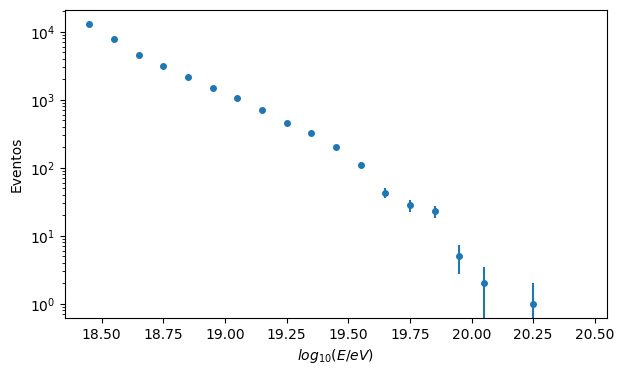

In [32]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set_xlabel('$log_{10}(E/eV)$')
ax.set_ylabel('Eventos')
ax.set_yscale("log")
ysigma = np.sqrt(ydata)
ax.errorbar(xdata, ydata, ysigma,ls='none', marker='o', ms=4, label='Datos')
plt.show()

## Modelo

The constant x0 is used to estabilize the fit

In [33]:
def modelo(x, theta, x0):
    return np.power(10, theta[0]-theta[1]*(x-x0) )

## Función de costo

Costo de un solo bin

In [34]:
def bin_cost(mu, k):
    if k==0:
        return 2*mu
    else:
        return 2*(mu-k)-2*k*np.log(mu/k)

Costo del ajuste

In [35]:
def funcion_costo(theta, xdata, ydata, x0):
        costo = np.zeros_like(theta[0])
        for (x1, y1) in zip(xdata, ydata):
            mu1 = modelo(x1, theta, x0)
            costo += bin_cost(mu1, y1)
        return costo

In [36]:
J = lambda theta: funcion_costo(theta, xfit, yfit, x0)

## Minimización

In [37]:
res = minimize(J, x0=(2, 2), method='BFGS', tol=1e-3)
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 14.046787065847292
        x: [ 2.162e+00  2.972e+00]
      nit: 8
      jac: [ 4.451e-04  6.223e-05]
 hess_inv: [[ 2.802e-04  7.208e-04]
            [ 7.208e-04  1.233e-02]]
     nfev: 30
     njev: 10

## Parámetros

In [38]:
theta_est = res.x
cova = 2 * res.hess_inv
error = np.sqrt( np.diagonal(cova) )
rho = cova[0][1]/(error[0]*error[1])
print(f'a = {theta_est[0]:.3f} ± {error[0]:.3f}')
print(f'b = {theta_est[1]:.3f} ± {error[1]:.3f}')
print(f'ρ = {rho:.2f}')

a = 2.162 ± 0.024
b = 2.972 ± 0.157
ρ = 0.39


## Dibujar ajuste

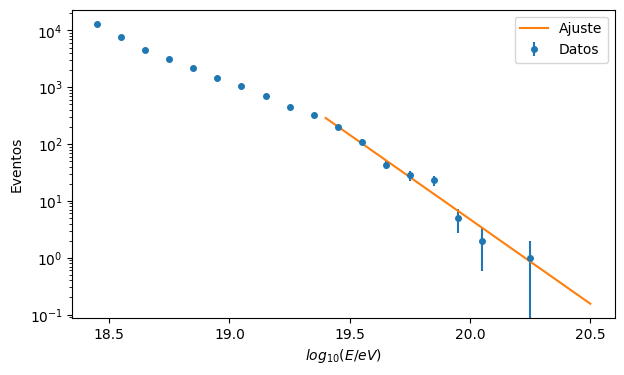

In [39]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set_xlabel('$log_{10}(E/eV)$')
ax.set_ylabel('Eventos')
ax.set_yscale("log")
ysigma = np.sqrt(ydata)
ax.errorbar(xdata, ydata, ysigma,ls='none', marker='o', ms=4, label='Datos')
x = np.linspace( xfit.min()-0.05, xfit.max()+0.05, 256)
mu_est = modelo(x, theta_est, x0)
ax.plot(x, mu_est, label='Ajuste')
ax.legend(fontsize='medium')

## Banda de error

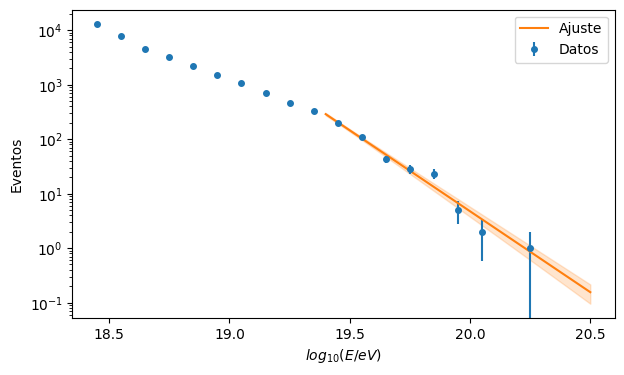

In [40]:
fig, ax = plt.subplots(figsize=(7,4))
ax.set_xlabel('$log_{10}(E/eV)$')
ax.set_ylabel('Eventos')
ax.set_yscale("log")
ysigma = np.sqrt(ydata)
ax.errorbar(xdata, ydata, ysigma,ls='none', marker='o', ms=4, label='Datos')
x = np.linspace( xfit.min()-0.05, xfit.max()+0.05, 256)
mu_est = modelo(x, theta_est, x0)
ax.plot(x, mu_est, label='Ajuste')
ax.legend(fontsize='medium')
grad_theta1 = math.log(10) * mu_est
grad_theta2 = (x-x0) * math.log(10) * mu_est
grad = np.column_stack( (grad_theta1, grad_theta2) )
sigma_mu_est = sda.fit_errors(grad, cova)
ax.fill_between(x, mu_est-sigma_mu_est, mu_est+sigma_mu_est, color='tab:orange', alpha=0.2)
plt.show()

## Bondad del ajuste

In [41]:
chi2_min = res.fun
ndof = len(xfit) - len(theta_est)
pvalor = chi2.sf(chi2_min, ndof)
print(f'χ²min = {chi2_min:.1f}')
print(f'ndof = {ndof}')
print(f'pvalor = {pvalor*100:.2}%')

χ²min = 14.0
ndof = 9
pvalor = 1.2e+01%


## Errores gráficos

Función de costo en una red discreta del espacio de parámetros

In [42]:
theta1 = np.linspace(theta_est[0]-4*error[0] , theta_est[0]+4*error[0], 100)
theta2 = np.linspace(theta_est[1]-4*error[1] , theta_est[1]+4*error[1], 100)
theta1, theta2 = np.meshgrid(theta1, theta2)
theta = np.array([theta1, theta2])
z = J(theta)

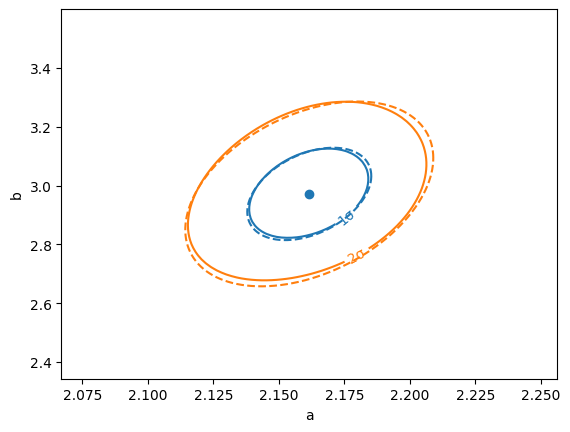

In [43]:
fig, ax = plt.subplots()
ax.set_xlabel('a')
ax.set_ylabel('b')

# estimador de máxima verosimilitud
ax.plot(*theta_est, 'o')

# errores gráficos
levels = chi2_min + np.array([1, 4])
contour = ax.contour(theta1, theta2, z, levels, colors=['tab:blue', 'tab:orange'])
fmt = {}
strs = ['1σ', '2σ']
for l, s in zip(contour.levels, strs):
    fmt[l] = s
ax.clabel(contour, fmt=fmt)

# errores parabólicos
elipse_1sigma = sda.get_ellipse(theta_est, cova, nsigma=1)
ax.plot(*elipse_1sigma, ls='--', color='tab:blue')
elipse_2sigma = sda.get_ellipse(theta_est, cova, nsigma=2)
ax.plot(*elipse_2sigma, ls='--', color='tab:orange')

plt.show()